# DESeq Workshop: Model Building and Analytic Approaches 

https://compbiocore.github.io/cbc-workshop-directory/

Some of the training material was borrowed from the Harvard Chan Bioinformatics Core (HBC) at: https://hbctraining.github.io/DGE_workshop/lessons/04_DGE_DESeq2_analysis.html

**Abstract**

This session starts with some model building basics and elementary experimental design for single cell sequence data. It then covers differential expression anaysis, including dicussions of normalization, library size scaling, and issues of multiple testing. Lastly, we go over network analysis, covering topics such as enrichment approaches, protein-protein interaction networks, gene set enrichment analysis, and coexpression networks. 

# Review - Model formulae

To begin, we must familiarize ourselves with the "model formula" interface in R. For important details complementary to this workshop, please explore the following link: 

[Model formulae tutorial](http://ww2.coastal.edu/kingw/statistics/R-tutorials/formulae.html)

* It is important to know the model formula interface because many regression functions in R use it.
* The formula determines the model that will be built (and tested) by the R procedure. The basic format is:

`> response variable ~ explanatory variables`

* The tilde means "is modeled by" or "is modeled as a function of." 

## Essential model formulae terminology

symbol  | example | meaning
------- | ------------ | --------------------------  
+ | + x	| include this variable  
-	| - x	| delete this variable  
:	| x : z	| include the interaction  
*	| x * z	| include these variables and their interactions  
^	| (u + v + w)^3	| include these variables and all interactions up to three way
1 | -1 | intercept: delete the intercept  

Note: order generally doesn't matter (u+v OR v+u)

*Examples*: `~treatment`, `~treatment + time`, `~treatment * time`


# The Design Matrix

## The Design Matrix

To build models, we must decide upon a design matrix. To illustrate this matrix, we will use an example of a multiple linear regression model:

$y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + \epsilon_i$

- $x_{ji}$ is the value of predictor $x_j$ for observation $i$

## The Design Matrix

Matrix notation for the multiple linear regression model:

$$
\,
\begin{pmatrix}
Y_1\\
Y_2\\
\vdots\\
Y_N
\end{pmatrix} = 
\begin{pmatrix}
1&x_1\\
1&x_2\\
\vdots\\
1&x_N
\end{pmatrix}
\begin{pmatrix}
\beta_0\\
\beta_1
\end{pmatrix} +
\begin{pmatrix}
\varepsilon_1\\
\varepsilon_2\\
\vdots\\
\varepsilon_N
\end{pmatrix}
$$

or simply: 

$$
\mathbf{Y}=\mathbf{X}\boldsymbol{\beta}+\boldsymbol{\varepsilon}
$$

* The design matrix is $\mathbf{X}$
    * which the computer will take as a given when solving for $\boldsymbol{\beta}$ by minimizing the sum of squares of residuals $\boldsymbol{\varepsilon}$.
    

It's important to note that there are multiple possible and reasonable design matrices for a given study design
* the model formula is used to encode a model matrix, for example, we can use the model formula in the code below to set up a design matrix with one factor variable:

In [2]:
group <- factor( c(1, 1, 2, 2) )
model.matrix(~ group)

,(Intercept),group2
1,1,0
2,1,0
3,1,1
4,1,1


What if we forgot to code group as a factor? The result is that R will enter the variable into the matrix as a single numeric variable, with different numbers representing group membership, as shown in the example below. This is different than the result one gets when using the factor() function, which gives k-1 dummy variables for indicating group membership, where k represents the number of groups. **When performing a regression, this can make a signficiant difference for your results, so it is important to be mindful of this coding!!**

<div class="alert alert-block alert-success"><b>Exercise:</b> Code a design matrix that includes a single variable of 1's and 2's but is coded as a non-factor (i.e., numeric); use the R code above as a starting poimt. What difference do you notice?  </div>

Moreover, the factor variable can have more than two levels or groupings. For example, if we have a single factor predictor variable representing three groups, the design matrix would be set up with k-1 (3-1) dummy variables as follows: 

In [6]:
group <- factor(c(1,1,2,2,3,3)) # factor variable with three groupings 
model.matrix(~ group)

,(Intercept),group2,group3
1,1,0,0
2,1,0,0
3,1,1,0
4,1,1,0
5,1,0,1
6,1,0,1


**Contrasts:** It's important to note that using dummy variables in our design matrix involves leaving one group out for comparative purposes.  The group left out of the design matrix is known as the _baseline_ group (or the reference level) and is the one that other groups are contrasted against. By default, R will choose the baseline group based on either numerical or alphabetical order. However, you may be interested in specific comparisons, and so will have a need to change the baseline group. You can change the baseline group manually as follows:

In [7]:
group <- factor(c(1,1,2,2,3,3)) # factor variable with three groups 
group <- relevel(x=group, ref=3) # use the ref argument to make group 3 our baseline group  
model.matrix(~ group)

,(Intercept),group1,group2
1,1,1,0
2,1,1,0
3,1,0,1
4,1,0,1
5,1,0,0
6,1,0,0


# Experimental Design 


## Single factor design

In single factor designs, you have a single factor predictor variable of interest, such as treatment condition. So, for example, you may have three mice who receive a treatment and three mice who do not and therefore serve as a control. This would look as follows: 

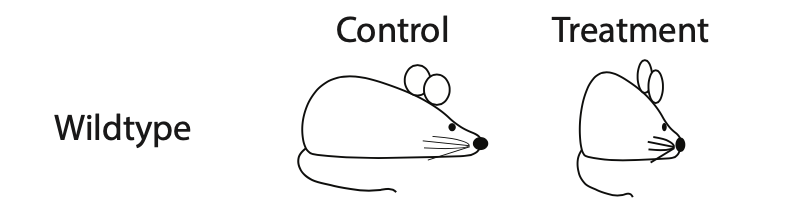

Under this design, you would be interested in the average group difference on the response variable between the two condition types. To examine something like this, we could code our design matrix as follows: 

In [1]:
# Single factor design 
condition <- factor( c("treatment", "treatment", "treatment", "control", "control", "control") )
model.matrix(~ condition)

,(Intercept),conditiontreatment
1,1,1
2,1,1
3,1,1
4,1,0
5,1,0
6,1,0


## Multi-factor design: Two factors 

The model matrix can be extended to represent multiple factor predictor variables, i.e. multiple (linear/log-linear/logistic) regression. This is useful, for example, in experiments where there are more than one factor influencing the outcome. In our previous mice example, let's say that in addition to condition, we introduced a variable capturing mutation. We would then want to account for this factor by adding it to the design and thus control for the additional variation in the outcome due to mice mutation/color. This illustration illustrates such a design: 

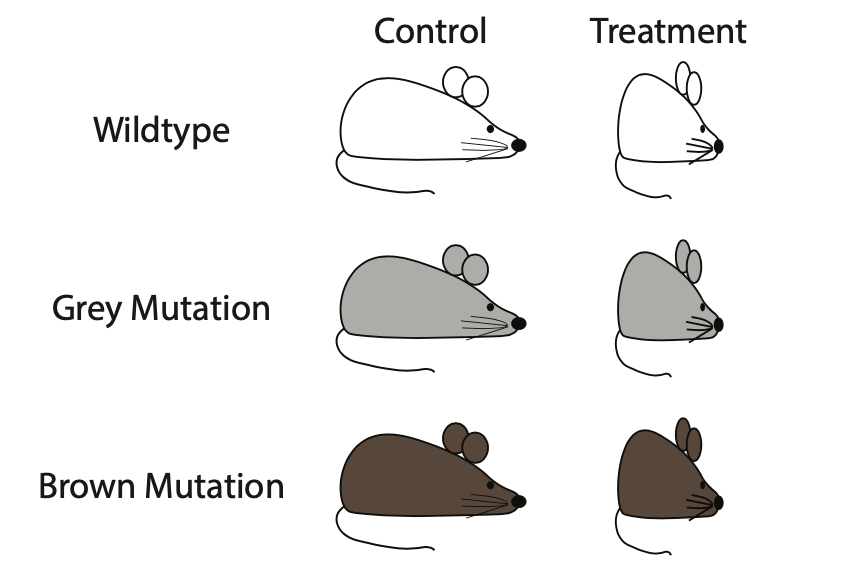

Another example is if you have experimental condition samples (i.e., treated vs untreated) that are balanced across experimental batches, you can include batch as a second factor to the design. A batch variable might be something like the day that you extracted the RNA from your sample or the cages the mice were kept in during the course of the experiment. In either case, the addition of factors to your design serves to control for additional variation in the outcome (i.e., counts) and increases the sensitivity for finding differences due to experimental condition. A table below illustrates a simple two-factor design with condition and sex. 

## Blocking 

Releated to multi-factor designs is the concept of blocking. Blocking is the arranging of experimental units into groups that are similar to one another. The differences between the "blocks" of individuals is "nuisance" variability that we want to control. In other words, we use this strategy to partial out (essentially remove) variability due to irrelavant factors in order to improve the accuracy and sensitivity of our estimates for variables that are of primary interest. 

 <img src="http://faculty.csupueblo.edu/paul.Chacon/156Spr05/images/block.jpg" alt="blocking" style="width:500px"> 

- In biology experiemtns, we typically use blocking to:
    + apply an experimental randomization to more homogeneous "blocks" of individuals (as shown in diagram above)

For example, we could use blocking to assign treated and control specimens, or case & control specimens, equally and randomly to batches. This would be referred to as **blocking on batch** and would be included as part of your experimental design. However, if such a consideration is not taken during the experimental design phase of your study, you can still control for nuisance variables, e.g., batch, afterwards by including the block as a factor in your regression analysis, as discussed and illustrated in the multi-factor design example. 

In [15]:
# Example of controlling for batch in regression analysis 
treatment <- factor( c( "treatment", "treatment", "treatment", "control", "control", "control") )
batch <- factor (c ("Cage_1", "Cage_1", "Cage_2", "Cage_1", "Cage_2", "Cage_2") )
model.matrix(~ condition + batch) #here we are blocking on batch, which is cage mice were kept in 

,(Intercept),conditiontreatment,batchCage_2
1,1,1,0
2,1,1,0
3,1,1,1
4,1,0,0
5,1,0,1
6,1,0,1


The above example includes batch as a factor in our regression analysis, thereby controlling nuisance variance. We now can get a better estimate of the effect associated with experimental condition. While this is an acceptable approach, note that it is always advised that you include blocking into your experimental design whenever possible. Incorporating a randomized block design is preferable to using blocks as controls in a regression because it often simplifies statistical analyses and allows for stronger, more credible inferences. 

## Interactions

When multiple factors are being considered, you are able to specify interaction terms via the : operator. Generally speaking, interaction terms tell us if the effect of one predictor on the response variable varies across the levels (or different values) of another predictor variable (see bar chart below for visual representation of this). 

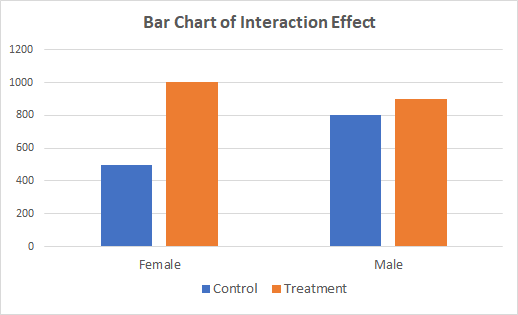 

We can specify a regression with two predictor variables and an interaction term as follows:

In [5]:
# Code for examining an interaction effect 
condition <- factor( c( "treatment", "treatment", "treatment", "control", "control", "control") )
sex <- factor (c ("female", "female", "male", "female", "male", "male") )
model.matrix(~ condition + sex + condition:sex) #here we use the : operator to include interaction effect 

,(Intercept),conditiontreatment,sexmale,conditiontreatment:sexmale
1,1,1,0,0
2,1,1,0,0
3,1,1,1,1
4,1,0,0,0
5,1,0,1,0
6,1,0,1,0


## Repeated Measures/Time Series 

It is important to briefly speak about data that includes multiple time points, as analyzing data arising from this design is not as straightforward. There are a number of ways to analyze time-series experiments, depending on the biological question of interest. In order to test for any differences over multiple time points, one can use a design including the time factor, and then test for time effects using the likelihood ratio test as described in the following section, where the time factor is removed in the reduced formula. For a control and treatment time series, one can use a design formula containing the condition factor, the time factor, and the interaction of the two (as discussed above). In this case, using the likelihood ratio test with a reduced model which does not contain the interaction term between condition and time will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0). An example of the later analysis is provided in our RNA-seq workflow. 

### Likelihood ratio test

DESeq2 offers the likelihood ratio test (LRT), which is a statistical test that assesses the goodness of fit between two competing models. This test is particularly useful for time-series experiments, as mentioned above. 
The hypothesis under this test examines two models for the counts, a full model with a certain number of terms and a reduced model, in which some of the terms of the full model are removed. The test determines if the increased likelihood of the data using the extra terms in the full model is more than expected if those extra terms are truly zero.

The LRT is therefore useful for testing multiple terms at once, for example, testing if there is a significant time by condition effect in a time series experiment. The LRT for count data is conceptually similar to an analysis of variance (ANOVA) calculation in linear regression, except that in the case of the Negative Binomial GLM, we use an analysis of deviance (ANODEV), where the deviance captures the difference in likelihood between a full and a reduced model.

The likelihood ratio test can be performed by specifying test="LRT" when using the DESeq function, and providing a reduced design formula, e.g. one in which a number of terms from design(dds) are removed (e.g., time x condition). The degrees of freedom for the test is obtained from the difference between the number of parameters in the two models. A likelihood ratio test for the control and treatment time-series experiment example, where the full design was ~condition + time + condition:time, would look like:

dds <- DESeq(dds, test="LRT", reduced=~condition + time)
res <- results(dds)

**Important Note:** The above is just one example of how to deal with time series data. In general, data involving measurements taken over time requires careful consideration, as repeated measurements create a statistical dependency in your data that needs to be accounted for. If this dependency structure goes unaccounted for or is inappropriately handled, your estimates, and thus the inferences you make, can become biased. Therefore, it is recommended that you consult with a statistician when analyzing repeated measure data. 

# Differential expression analysis

## R Packages for performing differential expression analyses 

- The first part of this workshop gave a broad overview of different approaches to exploring your RNAseq data and generating counts matrices and SummarizedExperiment objects.
- The counts matrices stored in the SummarizedExperiment objects can then be used for differential expression analysis.       

We could use a variety of Bioconductor packages for more exploration and differential expression analysis of the count data, including:
* [DESeq2](http://www.bioconductor.org/packages/DESeq2)
* [edgeR](http://www.bioconductor.org/packages/edgeR)
* [limma](http://www.bioconductor.org/packages/limma) (use Voom method for RNA-seq)

[Schurch *et al.* 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/27022035/) compared performance of different statistical methods
for RNA-seq using a large number of biological replicates and can help
users to decide which tools make sense to use, and how many
biological replicates are necessary to obtain a certain sensitivity. 

###  Comparison of edgeR / DESeq2 / limma-voom

**DESeq2**, **edgeR**, and **limma-voom** are all well-documented packages. They each implement similar key features:        

* Empirical Bayes "regularization" or "shrinkage" of expression variance
   + borrows prior expectation for variance from all genes, reduces false positives in small samples
* Use of model formula, model matrices, and contrasts for flexible differential expression analysis      
* Reporting of log fold-change and False Discovery Rate 

Some ways they differ are:
* Error terms used: **DESeq2** and **edgeR** use log-linear Generalized Linear Model with negative binomial error term , **limma-voom** uses linear regression on transformed counts     
    
* **DESeq2** "automagically" handles independent filtering, using Independent Hypothesis Weighting ([IHW package](http://www.bioconductor.org/packages/IHW))
* Speed (**limma-voom** is much faster and should definitely be used if you have hundreds of samples)
* Approaches to hierarchical modeling, e.g. samples nested within groups
    + limma-voom has a built-in feature for sample correlations (called *duplicateCorrelation*)
* Re-use of core Bioconductor structures (DESeq2 extends *SummarizedExperiment*, edgeR and limma create their own)

DEseq2 is generally a practical and simple pipeline to run.  However, for large datasets, especially if doing permutations for gene set enrichment analysis, limma with its voom method is far more practical. It is worth noting that for large sample sizes, it hardly matters which error model you use, owing to the Central Limit Theorem. 

**Note that we will continue using [DESeq2](http://www.bioconductor.org/packages/DESeq2), starting from the *SummarizedExperiment* object** 

## Running the differential expression pipeline

To begin the analysis, you input your count matrix as well as specify your experiment design (i.e., model formula) into the DESeqDataSet() function. Once this has been specified, we can run the differential expression pipeline on
the raw counts with a single call to the function *DESeq*:

In [10]:
suppressPackageStartupMessages({
    library(DESeq2)
    library(airway)
    library('org.Hs.eg.db')
    library(enrichplot)
})
data(airway)
dds <- DESeqDataSet(airway, design = ~ cell + dex) # count matrix and experiment design here 
dds <- DESeq(dds) # run differential expression analysis pipeline 

ERROR: Error in library(DESeq2): there is no package called ‘DESeq2’


**Note:** This function will print out a message for the various steps it
performs. These steps are: 

1.) the estimation of size factors (normalization); 

2.) the estimation of dispersion values for each gene; 

3.) and fitting a generalized linear model (GLM) with Wald tests.

A *DESeqDataSet* is returned that contains all the fitted
parameters within it, and the following section describes how to
extract out results tables of interest from this object.

The steps performed the DESeq() function are described in more detail below and in the manual page for
*DESeq*, which can be accessed by typing `?DESeq`.

### Normalization: A Note on Counts in DESeq2 

The starting point of the DESeq2 analysis is a count matrix. Given the count matrix, the first step in a differential expression analysis workflow is to perform count normalization so that we can make accurate comparisons of gene expression between samples. Normalization is the process of scaling raw count values to account for the factors we are not interested in. These are factors such as sequencing depth, gene length, and RNA composition. By accounting for such factors, we ensure that expression levels are more comparable between and/or within samples. 

It is important to note that DESeq2 automatically handles normalization internally when performing its analysis. It does so in an attempt to avoid the effects of count magnitude on differential expression status - otherwise, nonsignificant genes with very large counts would appear as false positives and significant genes with very small counts would appear as false negatives.So when we run the DESeq analysis pieline, 

Common methods of normalization include Trimmed Mean of M-Values (TMM), Relative Log Expression (RLE), and Median Ratio Normalization (MRN). TMM, used by the edgeR package, and RLE, yield very similar results. The R package that we are using, the DESeq2 package, uses the RME approach, which accounts for sequencing depth and RNA composition. Given that tools for differential expression analysis are comparing the counts between sample groups for the same gene, gene length is a factor that does not need to be accounted for with this design. To see see more specific details regarding the RME normalization approach used by DESeq2, please see the following resource: 

**Next, a word of caution.** When obtaining a result from the DESeq() function highlighting a list of genes, people will often look back at their original count table using a program like Excel and examine the counts tabulated therein. Doing so is inadvisable and misleading, as these non-normalized counts are not proper indicators of significance.

Here, we will show how different normalized and nonnormalized counts can be, illustrating the importance of normalization. Note that these plots are on the log scale, so a linear distance represents an exponential change. Very low counts are unaffected by normalization, as the normalization process adds a 0.5 pseudocount, but higher counts change substantially. Here, the two lower counts in the treatment group are almost halved and almost doubled in magnitude, respectively - an enormous change that would be misleading if viewed without factoring in the normalization.

#### Counts plot
A quick way to visualize the counts for a particular gene is to use the plotCounts function that takes as arguments the DESeqDataSet, a gene name, and the group over which to plot the counts (figure below).

In [ ]:
plotCounts(dds, gene = "ENSG00000132518", intgroup=c("dex"), main = "Normalized")
plotCounts(dds, gene = "ENSG00000132518", intgroup=c("dex"), normalized = F, main = "Non-normalized")

### Dispersion Estimation

The next step in differential expression analysis is the estimation of gene-wise dispersions. **What is dispersion and what does it represent?** Simply put, dispersion is a measure of spread or variability in the data. The measure of dispersion used with DESeq2 is related to both the mean and variance of the data. **Specifically, The DESeq2 dispersion estimates are inversely related to the mean and directly related to variance.** Based on this relationship, the dispersion is higher for small mean counts and lower for large mean counts. The dispersion estimates for genes with the same mean will differ only based on their variance. Therefore, the dispersion estimates reflect the variance in gene expression for a given mean value. 

The plot of mean versus variance in count data below shows the variance in gene expression increases with the mean expression (each black dot is a gene). Notice that the relationship between mean and variance is linear on the log scale, and for higher means, we could predict the variance relatively accurately given the mean. **However, for low mean counts, the variance estimates have a much larger spread; therefore, the dispersion estimates will differ much more between genes with small means.**

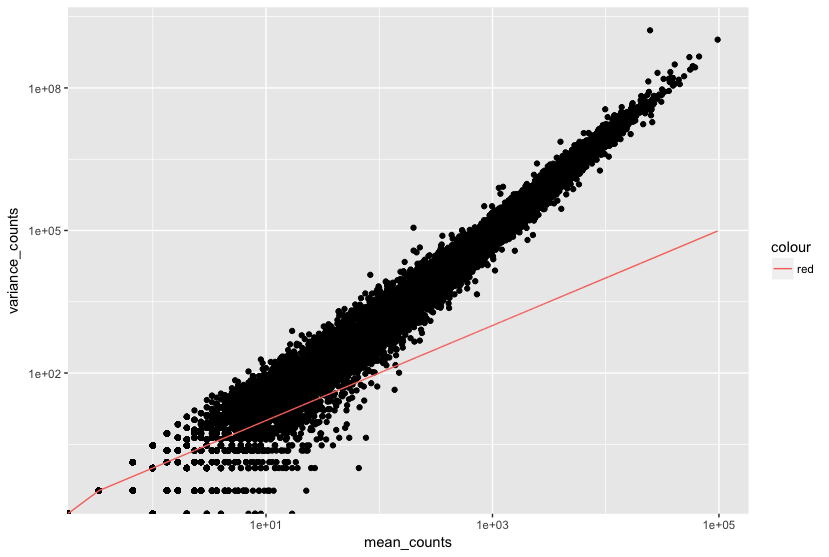

**Why does dispersoon matter for our modelling process?** To accurately model sequencing counts, we need to generate accurate estimates of within-group variation (variation between replicates of the same sample group) for each gene. With only a few (3-6) replicates per group, the estimates of variation for each gene are often unreliable (due to the large differences in dispersion for genes with similar means).

To address this problem, DESeq2 shares information across genes to generate more accurate estimates of variation based on the mean expression level of the gene using a method called ‘shrinkage’. DESeq2 assumes that genes with similar expression levels have similar dispersion.

**Estimating the dispersion for each gene separately:** To model the dispersion based on expression level (mean counts of replicates), the dispersion for each gene is estimated using maximum likelihood estimation. Maximum likelihood is an approach for estimating a parameter(s) by maximizing what's known as a likelihood function. The likelihood function is simply a function representing the support the data provides for each value of the parameter (e.g., dispersion). Thus, given the count values of the replicates, the most likely estimate of dispersion is calculated.

**Fit curve to gene-wise dispersion estimates:** The next step in the workflow is to fit a curve to the dispersion estimates for each gene. The idea behind fitting a curve to the data is that different genes will have different scales of biological variability, but, over all genes, there will be a distribution of reasonable estimates of dispersion.

This curve is displayed as a red line in the figure below, which plots the estimate for the expected dispersion value for genes of a given expression strength. Each black dot is a gene with an associated mean expression level and maximum likelihood estimation (MLE) of the dispersion (Step 1).

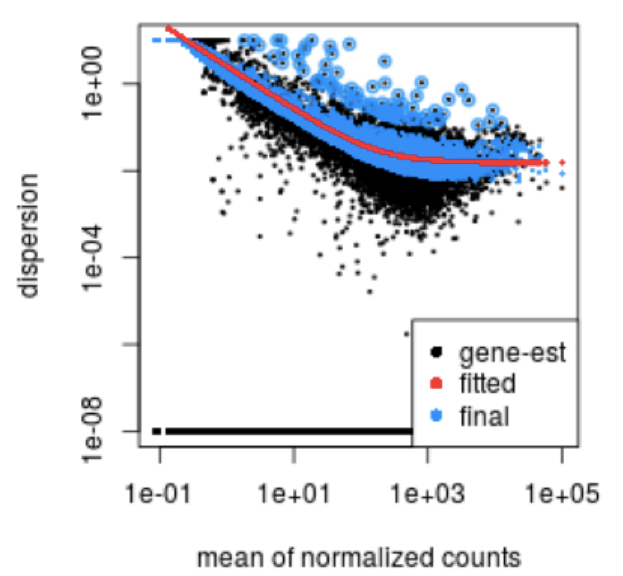


**Shrink gene-wise dispersion estimates toward the values predicted by the curve**
The next step in the workflow is to shrink the gene-wise dispersion estimates toward the expected dispersion values.

The curve allows for more accurate identification of differentially expressed genes when sample sizes are small, and the strength of the shrinkage for each gene depends on :

how close gene dispersions are from the curve

sample size (more samples = less shrinkage)

This shrinkage method is particularly important to reduce false positives in the differential expression analysis. Genes with low dispersion estimates are shrunken towards the curve, and the more accurate, higher shrunken values are output for fitting of the model and differential expression testing.

Dispersion estimates that are slightly above the curve are also shrunk toward the curve for better dispersion estimation; however, genes with extremely high dispersion values are not. This is due to the likelihood that the gene does not follow the modeling assumptions and has higher variability than others for biological or technical reasons [1]. Shrinking the values toward the curve could result in false positives, so these values are not shrunken. These genes are shown surrounded by blue circles below.

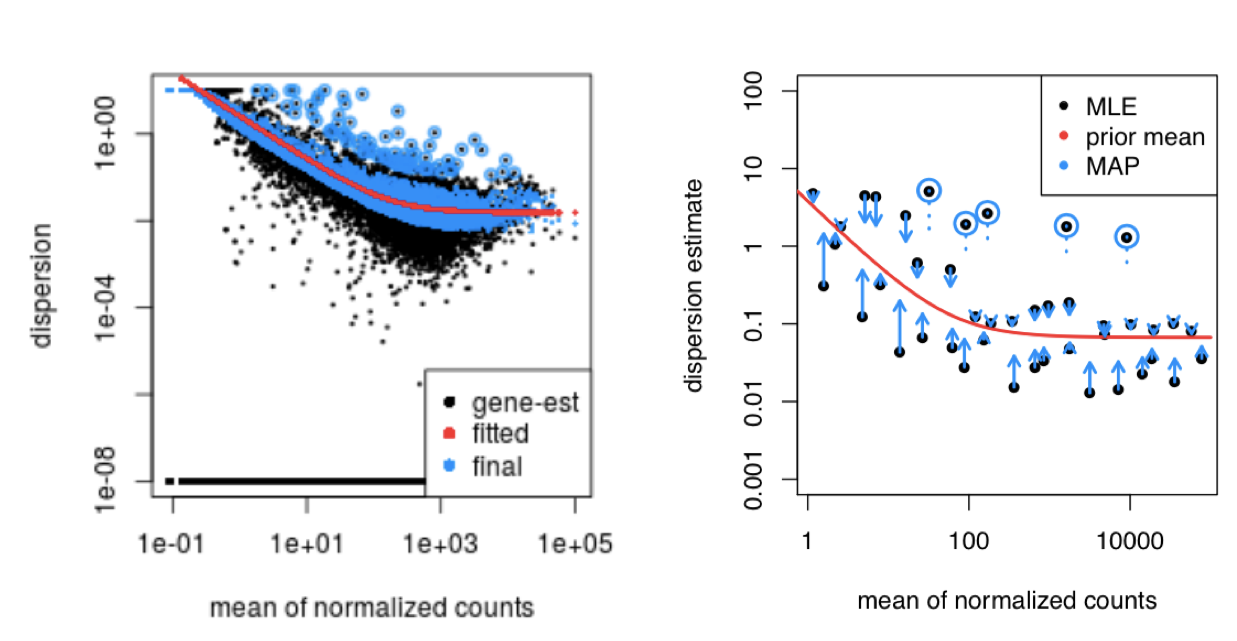

This is a good plot to examine to ensure your data is a good fit for the DESeq2 model. You expect your data to generally scatter around the curve, with the dispersion decreasing with increasing mean expression levels. If you see a cloud or different shapes, then you might want to explore your data more to see if you have contamination (mitochondrial, etc.) or outlier samples. Note how much shrinkage you get across the whole range of means in the plotDispEsts() plot for any experiment with low degrees of freedom.

Examples of worrisome dispersion plots are shown below:

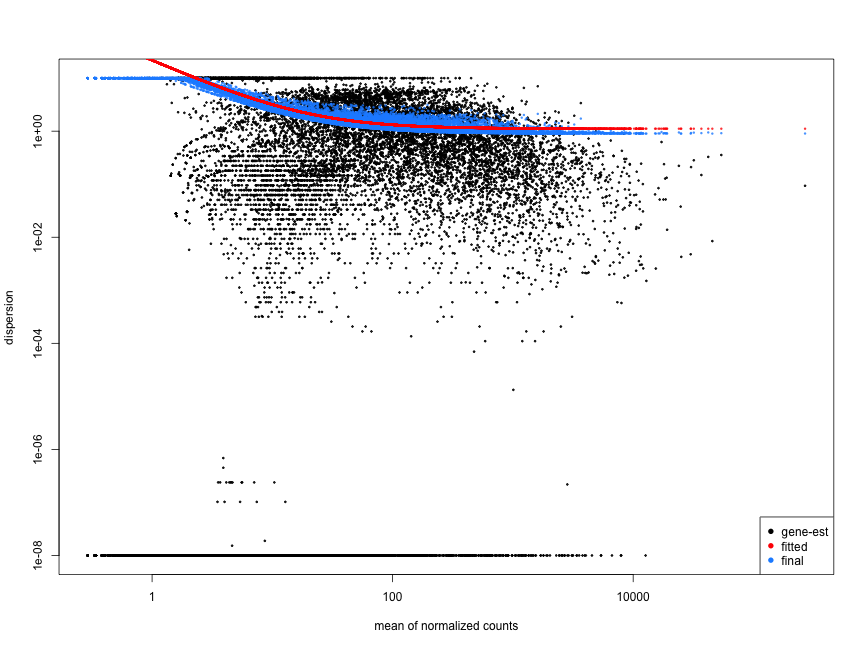

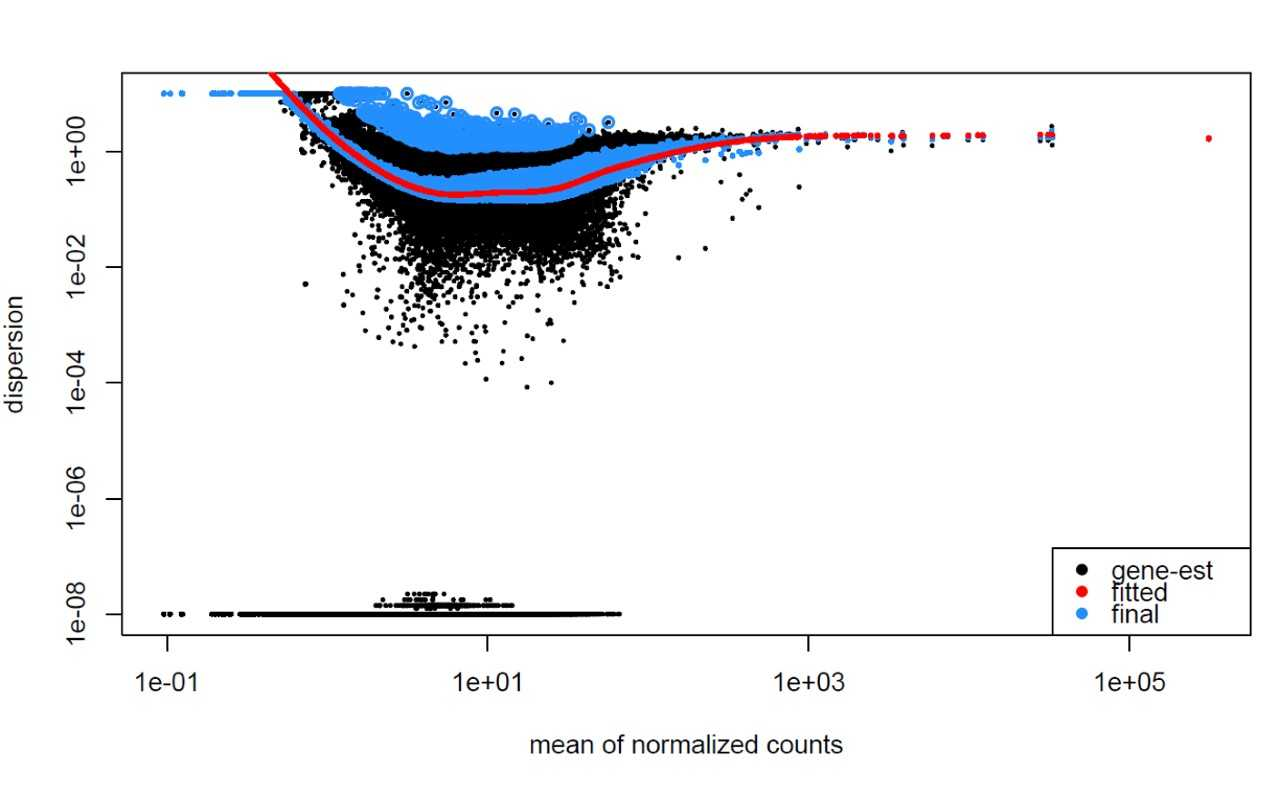


### Hypothesis Testing: Wald test

The count data we work with for differential expression is assumed to follow a negative binomial distribution (Poisson-like), and thus the DESeq2 authors model the data as such. Specifically, after estimating dispersion, DESeq2 fits a negative binomial regression model to each gene to make inferences about differential expression. To make these inferences, we perform hypothesis testing on the regression coefficients in the negative binomial regression model using the Wald test. 

**Hypothesis testing**

The first step in hypothesis testing is to set up a null hypothesis for each gene. In our case, the null hypothesis is that there is no differential expression across sample groups (i.e., regression coefficient == 0). Notice that we can do this without observing any data, because it is based on a thought experiment. Subsequently, we use a statistical test to determine if, based on the observed data, we should accept the null hypothesis as being true. 

**Wald test**

With DESeq2, the Wald test is the default used for hypothesis testing when comparing two groups. The Wald test is a test of hypothesis usually performed on parameters that have been estimated via maximum likelihood. Maximum likelihood is just an estimation method for deriving the parameters to a statistical model. In our case, we are testing each gene model coefficient (i.e., regression coefficient) to see if it is significantly different from zero.  

**DESeq2 implements the Wald test by:**

1.) Regression coefficients of the model are estimated for each sample group along with their standard error. Note that in DE the coefficents are the estimates for the log2 foldchanges for each sample group.

2.) Take the regression coefficient and divide it by its standard error, which results in a z-statistic

3.) The z-statistic is then compared to a standard normal distribution, and from this a p-value is derived. which reports the probability of observing a z-statistic at least as extreme as the one we observed, given that the null hypothesis is true

4.) If the p-value is small, we reject the null hypothesis and state that there is evidence against the null (i.e. the gene is differentially expressed) 

<div class="alert alert-block alert-warning"><b>Note:</b> The Wald test and the previously discussed Likelihood Ratio Test (LRT) are essentially the same thing and test the same hypothesis. The big difference is their finite sample performance. Specifically, in smaller to moderate sample sizes, the LRT is to be preferred, as the Wald test becomes less reliable. </div>

## Building the results table

Calling `results` without any arguments will extract the estimated
log2 fold changes and p-values **for the last variable in the design
formula**. If there are more than 2 levels for this variable, `results`
will extract the results table for a comparison of the last level over
the first level.

Here, our model was `~ cell + dex`, so the default comparison printed at the top of the output is
`dex trt vs dex untrt`.  As the `airway` dataset's `dex` variable only has two levels, there is no need to worry about explicitly specifying level comparisons in this case.

In [1]:
suppressPackageStartupMessages({
    library('DESeq2')
    library('airway')
    library('biomaRt')
    library('dplyr')
    library('apeglm')
    library('tidyr')
})
data(airway)

As in the previous workshop, we can turn the `RangedSummarizedExperiment` into a `DESeqDataSet`:

In [2]:
dds <- DESeqDataSet(airway, design = ~ cell + dex)
dds

class: DESeqDataSet 
dim: 64102 8 
metadata(2): '' version
assays(1): counts
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

We can look at the factor levels of `dex`

In [3]:
levels(colData(dds)$dex)

[1] "trt"   "untrt"

We probably want `untrt` to be our reference level (although this isn't super critical when there are only two factor levels).

In [4]:
colData(dds)$dex <- relevel(colData(dds)$dex, ref = 'untrt')
levels(colData(dds)$dex)

[1] "untrt" "trt"

Use the `DESeq` function to run differential expression analysis

In [5]:
dds <- DESeq(dds)
dds

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 64102 8 
metadata(2): '' version
assays(4): counts mu H cooks
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(34): baseMean baseVar ... deviance maxCooks
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(10): SampleName cell ... BioSample sizeFactor

This function will print out a message for the various steps it performs. These are described in more detail in the manual page for DESeq, which can be accessed by typing '?DESeq'. Briefly these are: the estimation of size factors (controlling for differences in the sequencing depth of the samples), the estimation of dispersion values (the spread or variability) for each gene, and fitting a generalized linear model (GLM).

A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

## A Note on Statistical Terminology 

* For large samples, violations of distributional assumptions have diminishing importance
* A sampling distribution is a probability distribution of a statistic (e.g., the mean) obtained from repeated random sampling
* _Standard Error_ is the standard deviation of a normally distributed sampling distribution
* The null hypothesis is an assumption about the form of a sampling distribution

We have thus far defined the p-value with respect to the null hypothesis, but have yet to state what the null hypothesis actually means.  Generally, in a biological experiment, the null hypothesis is that there is no difference between two (or more) different groups according so some metric being studied e.g. gene expression.  The alternative hypothesis is that there is some difference.  To determine which of these hypotheses is more likely to be correct, we calculate a p-value.

**p-value:** the probability of getting a result at least as extreme as the one observed *given* that the null hypothesis is true.

Thus, a low p-value means it's unlikely that you'd see what you're seeing if the null hypothesis is true, providing evidence that the null hypothesis is not true - in classical statistics, if that probability is lower than .05 (5%), we *reject the null hypothesis*.  Note that this is not strictly identical to as *accepting the alternative hypothesis*, but with the null rejected, we only have the alternative hypothesis left (under this framework).

## A Note On Multiple testing

In high-throughput biology, we are careful to not use the p-values
directly as evidence against the null, but instead to correct for
*multiple testing*. The reason we do this is because we are running multiple (sometimes thousands of) hypothesis tests when performing differential expression analysis, and this increases the chances of observing false positives (Type I error). To deal with this, *DESeq2* uses the [Benjamini-Hochberg (BH)](https://www.jstor.org/stable) adjustment as implemented in
the base R `p.adjust` function; in brief, this method calculates, for
each gene, an adjusted p-value that answers the following question:
if one called significant all genes with an adjusted p-value less than or
equal to this gene's adjusted p-value threshold, what would be the fraction
of false positives (the *false discovery rate*, FDR) among them, in
the sense of the calculation outlined above? These values, called the
BH-adjusted p-values, are given in the column `padj` of the `res`
object.


The BH correction is appropriate in the sense that it is not as overlyconservative as other correction approaches and maintains the desired coverage rate; however, it is important to note that this aproach isn't robust to violations of indepednence. This can be problematic in our context because the multiple hypothesis tests performed in differential expression analysis may very well be dependent. To deal with this, we can use a Bonferroni correction appraoch, which simply involves dividing the conventional p-value (usually 0.05) by the number of hypothesis tests being performed. This then creates a new nominal p-value against which the observed p-values are compared for signficiance. This can be done in DESeq2 by using the `p.adjust="Bonferroni"` argument. This approach is more robust to violations of independence than the BH correction; however, it is also important to note that this approach is known to be overlyconservative and thus it is harder to achieve signficance with. 



## Other comparisons

The results for a comparison of any two levels of a variable can be extracted using the `contrast` argument to *results*. The user should specify three values: 
- the name of the variable   
- the name of the level for the numerator    
- and the name of the level for the denominator       

Here we extract results for the log2 of thefold change of one cell line over another. We will explicitly specify which cell lines to compare since there are more than two levels:

In [ ]:
results(dds, contrast = c("cell", "N061011", "N61311"))

There are additional ways to build results tables for certain comparisons after running *DESeq* once. If results for an interaction term are desired, the `name` argument of `results` should be used. Please see the help page for the `results` function for details on the additionalways to build results tables. In particular, the **Examples** section ofthe help page for `results` gives some pertinent examples.

We subset the results table to these genes and then sort it by the
log2 fold change estimate to get the significant genes with the
strongest downregulation:

In [ ]:
resSig <- subset(res, padj < 0.1)
head(resSig[ order(resSig$log2FoldChange), ])

...and with the strongest upregulation:

In [ ]:
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])

# Diagnostic plots

## MA-plot

An *MA-plot* ([Dudoit et al., Statistica Sinica, 2002](http://wwwf.imperial.ac.uk/~das01/BioinformaticsMSc/Papers/sinica.final.pdf)) provides a useful overview for
the distribution of the estimated coefficients in the model,
i.e. the comparisons of interest, across all genes.
On the y-axis, the "M" stands for "minus" --
subtraction of log values is equivalent to the log of the ratio -- and
on the x-axis, the "A" stands for "average". You may hear this plot
also referred to as a "mean-difference plot", or a "Bland-Altman plot".

Before making the MA-plot, we use the
`lfcShrink` function to shrink the log2 fold-changes for the
comparison of dex treated vs untreated samples:

In [ ]:
res <- results(dds)
res <- DESeq2::lfcShrink(dds, coef = "dex_trt_vs_untrt", res = results(dds))
DESeq2::plotMA(res, ylim=c(-5,5))

**An MA-plot of changes induced by treatment.**
The log2 fold-change for a particular
comparison is plotted on the y-axis and the average of the counts
normalized by size factor is shown on the x-axis.
Each gene is represented with a dot. Genes with an adjusted *p* value
below a threshold (here 0.1, the default) are shown in blue.      

The *DESeq2* package uses a Bayesian procedure to moderate (or
"shrink") log2 fold changes from genes with very low counts and highly
variable counts, as can be seen by the narrowing of the vertical
spread of points on the left side of the MA-plot. As shown above, the
`lfcShrink` function performs this operation.  For a detailed
explanation of the rationale of moderated fold changes, please see the
*DESeq2* paper ([Love and Huber, Genome Biology, 2014](http://wwwf.imperial.ac.uk/~das01/BioinformaticsMSc/Papers/sinica.final.pdf)).

If we had not used statistical moderation to shrink the noisy log2
fold changes, we would have instead seen the following plot:

In [ ]:
res.noshr <- results(dds)
plotMA(res.noshr, ylim = c(-5, 5))


We can label individual points on the MA-plot as well. Here we use the
`with` R function to plot a circle and text for a selected row of the
results object. Within the `with` function, only the `baseMean` and
`log2FoldChange` values for the selected rows of `res` are used.

In [ ]:
plotMA(res, ylim = c(-5,5))
topGene <- rownames(res)[which.min(res$padj)]
with(res[topGene, ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, topGene, pos=2, col="dodgerblue")
})


Another useful diagnostic plot is the histogram of the p-values
(figure below). This plot is best formed by excluding genes with very
small counts, which otherwise generate spikes in the histogram.

In [ ]:
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", main = "p-value Histogram", xlab = "p-value")

**Histogram of *p* values for genes with mean normalized count larger than 1.**

## Volcano plot

A typical volcano plot is a scatterplot of $-log_{10}$(p-value) vs. $log_2$(fold-change). It allows you to visualize the difference in expression between groups against the statistical significance of that difference. Some things to look for:
* are diffentially expressed genes skewed towards up or down-regulation?
* are there a lot of significant but very low fold-change genes? This can result from a confounded batch effect.

In [ ]:
volcanoPlot <- function(res, lfc=2, pval=0.01){
    tab = data.frame(logFC = res$log2FoldChange, negLogPval = -log10(res$pvalue))
    plot(tab, pch = 16, cex = 0.6, xlab = expression(log[2]~fold~change), ylab = expression(-log[10]~pvalue))
    signGenes = (abs(tab$logFC) > lfc & tab$negLogPval > -log10(pval))
    points(tab[signGenes, ], pch = 16, cex = 0.8, col = "red") 
    abline(h = -log10(pval), col = "green3", lty = 2) 
    abline(v = c(-lfc, lfc), col = "blue", lty = 2) 
    mtext(paste("pval =", pval), side = 4, at = -log10(pval), cex = 0.8, line = 0.5, las = 1) 
    mtext(c(paste("-", lfc, "fold"), paste("+", lfc, "fold")), side = 3, at = c(-lfc, lfc), cex = 0.8, line = 0.5)
}
volcanoPlot(res)

# Ontology Analysis

Now that we have information about which genes are differentially expressed, we can see if there is any enrichment in any functional gene groups. Two commonly used methods to look for enrichment are overrepresentation analysis (ORA) or gene set enrichment analysis (GSEA). **Over Representation Analysis (ORA)** looks for functions or processes that are over-represented (= enriched) in an experimentally-derived gene list. The background used by default is all of the genes that have an annotation. This will find genes where the difference is large, but will not detect a situation where the difference is small but coordinated across a set of genes. **Gene Set Enrichment (GSEA)** aggregates per-gene statistics across genes in a set. It takes a ranked list of genes and determines whether members of a gene set are randomly distributed throughout that list or if they are found primarily at the top or bottom of the list. GSEA will calculate an enrichment score based on whether a gene set is over-represented at the top or bottom fo the list, estimate the significance of the enrichment, and adjust for multiple hypothesis testing. 

There are many packages for running these types of analyses ([gage](https://www.bioconductor.org/packages/release/bioc/html/gage.html), [EnrichmentBrowser](https://www.bioconductor.org/packages/release/bioc/html/EnrichmentBrowser.html)) and many of them will use similar approaches to test for enrichment. We will use [clusterProfiler](https://www.bioconductor.org/packages/release/bioc/html/clusterProfiler.html).

We will use [gene ontologies](http://geneontology.org/docs/ontology-documentation/) to organize the genes into groups based on their role in an organism. Gene Ontology loosely organize genes into three hierarchical graphs that correspond to three large umbrella categories -- **Molecular Function, Cellular Component, and Biological Process**. You can read the formal descriptions of these categories in the documentation linked above. A quote from the documentation illustrates an example of how these categories are related:

```
In an example of GO annotation, the gene product “cytochrome c” can be described by the molecular function oxidoreductase activity, the biological process oxidative phosphorylation, and the cellular component mitochondrial matrix.
```

First, let's get the annotations -- this time we'll use [AnnotationHub](https://www.bioconductor.org/packages/release/bioc/html/AnnotationHub.html). Load the packages and query AnnotationHub for a Homo sapiens OrgDb:


In [7]:
library(AnnotationHub)
#BiocManager::install("clusterProfiler")
library(clusterProfiler)
ah <- AnnotationHub()
AnnotationHub::query(ah, pattern = c("Homo sapiens", "OrgDb"))

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘AnnotationHub’


The following object is masked from ‘package:Biobase’:

    cache




clusterProfiler v3.16.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:DelayedArray’:

    simplify


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked fro

AnnotationHub with 1 record
# snapshotDate(): 2020-04-27
# names(): AH79577
# $dataprovider: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/
# $species: Homo sapiens
# $rdataclass: OrgDb
# $rdatadateadded: 2020-05-01
# $title: org.Hs.eg.db.sqlite
# $description: NCBI gene ID based annotations about Homo sapiens
# $taxonomyid: 9606
# $genome: NCBI genomes
# $sourcetype: NCBI/ensembl
# $sourceurl: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/, ftp://ftp.ensembl.org/p...
# $sourcesize: NA
# $tags: c("NCBI", "Gene", "Annotation") 
# retrieve record with 'object[["AH79577"]]' 

Let's assign the OrgDb `AH79577` to an obect so we can use it later, you can use `keytypes(orgdb)` after to see what gene ID types are available.

In [16]:
orgdb <- AnnotationHub::query(ah, pattern = c("Homo sapiens", "OrgDb"))[['AH79577']]

ERROR: Error in loadNamespace(name): there is no package called ‘AnnotationHub’


We will use the functions `gseGO` and `enrichGO` from clusterProfiler.

- `gseGO` is a GSEA method, it takes a order ranked geneList as input and uses a Kolmogorov Smirnov test to run Gene Set Enrichment Analysis (GSEA) [Subramanian et al. 2005](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/16199517/). GSEA is useful in scenarios where the fold changes are subtle but modules of genes are regulated in a coordinated way. 

- `enrichGO` is an ORA method and takes a list of genes (does not neet to be ranked) and uses Fisher's exact test with a hypergeometric distribution to run Enrichment Analysis [Boyle et al. 2004](https://academic.oup.com/bioinformatics/article/20/18/3710/202612). 

First, lets make a ranked geneList from our DESeq2 results, such that genes with the strongest up regulation are at the top and genes with the strongest down regulation are at the bottom. First we will drop rows with `NA`

In [9]:
#library('tidyr')
#res.original <- res
res <- tidyr::drop_na(data.frame(res))

In [10]:
gene_list <- res$log2FoldChange
names(gene_list) <- c(rownames(res))
gene_list <- sort(gene_list, decreasing = TRUE)

Then we can run `gseGO`. We are setting a seed and using the `seed = TRUE` argument because we want gseGO to deal with ties consistently -- otherwise we might get different data every time we run the analysis since gseGO will arbitrarily break ties in the rankings. The ties shouldn't present a huge issue as long as the ties percentage in your data is low.

In [17]:
set.seed(42)
gsea_out <- gseGO(
    geneList = gene_list,
    OrgDb = orgdb,
    ont = 'ALL',
    keyType = 'ENSEMBL',
    seed = TRUE)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



- By using `keyType = 'ENSEMBL'` we are telling the function that our gene IDs are in `ENSEMBL` format and by setting `ont = 'ALL'` we are indicating we want to look at all three of the ontologies -- `Biological Process`, `Cellular Component`, and `Molecular Function`. Run `?gseGO` for a full account of the function and its arguments      

- There are many options for visualizing the enrichment, you can see more details [here](http://yulab-smu.top/clusterProfiler-book/chapter12.html) -- let's start with a dotplot:

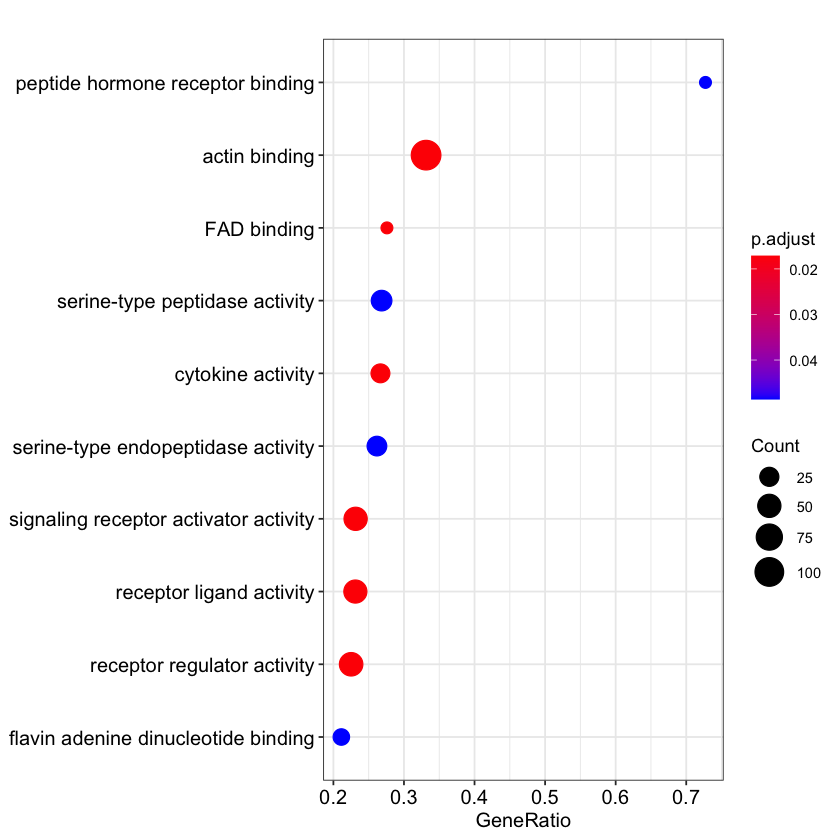

In [16]:
library(enrichplot)
dotplot(gsea_out)

The size of the dot indicates how many members of the group are represented in the enrichment and the adjusted p-value is the Benjamini-Hochberg corrected p-value. `GeneRatio` is `k/n`, where for a given category (e.g. 'receptor regulator activity') `k` is the overlap of 'receptor regulator activity' genes in `gene_list` compared to all 'receptor regulator activity' genes in the org.db, where `n` is the overlap of all genes in `gene_list` compares to all genes in the org.db.

You can also use `emapplot`, which will group genes in overlapping categories:

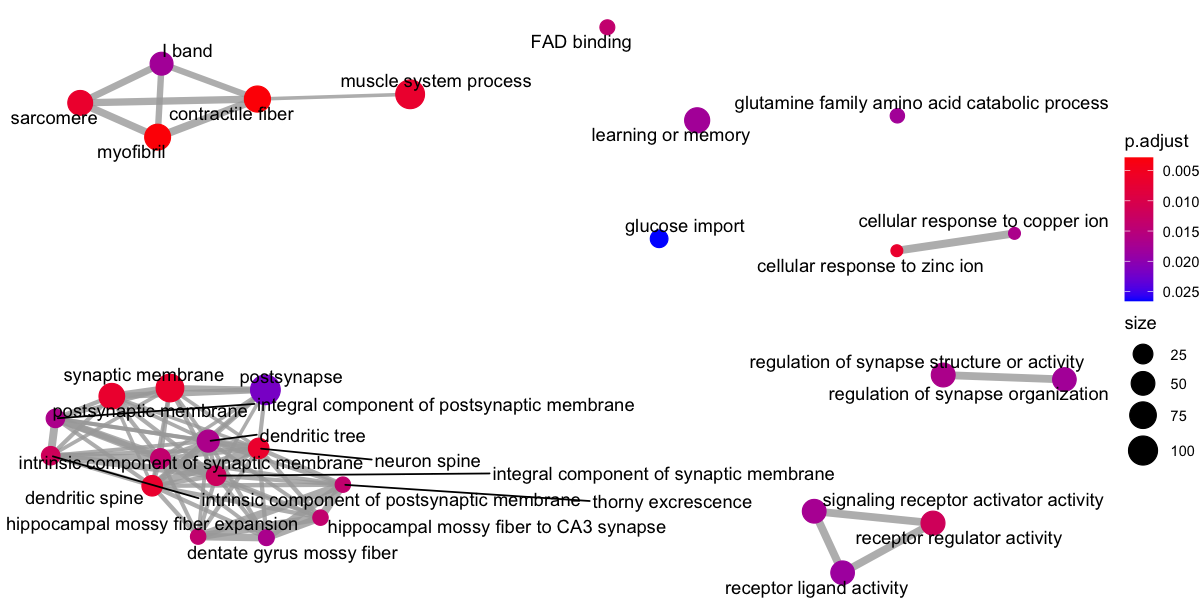

In [19]:
options(repr.plot.height=5, repr.plot.width=10)
emapplot(gsea_out)

We can also use `enrichGO`, which takes a list of genes that are not ranked. We will separate out the up and down regulated genes from `res` first.

In [20]:
up_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange > 0)
down_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange < 0)

Then we can run `enrichGO` on the up and down regulated genes and make dotplots.

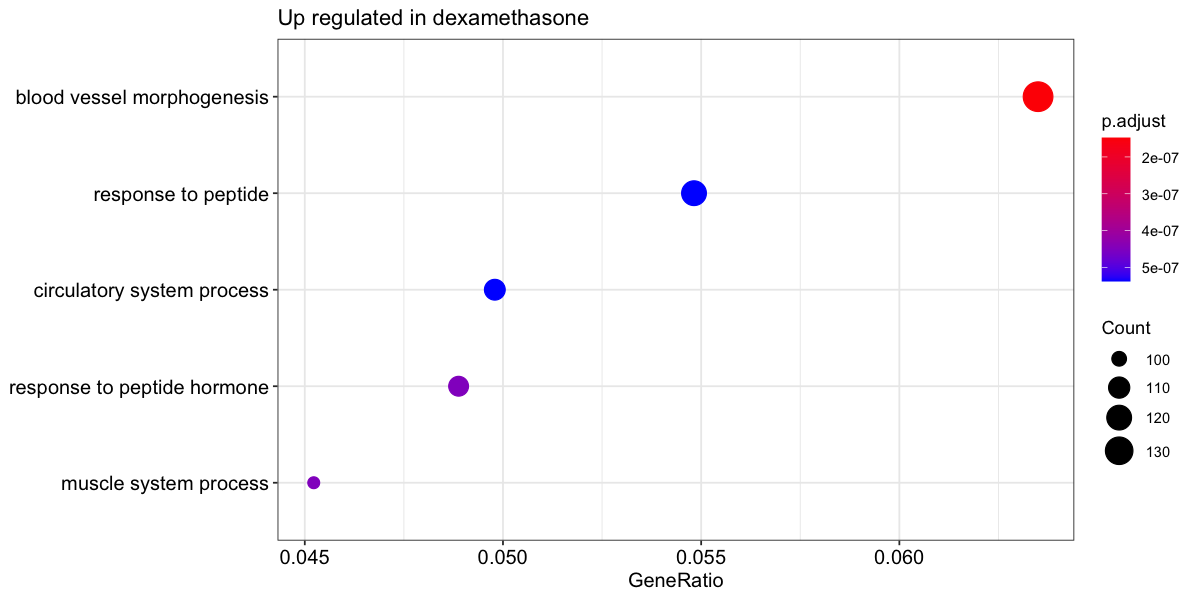

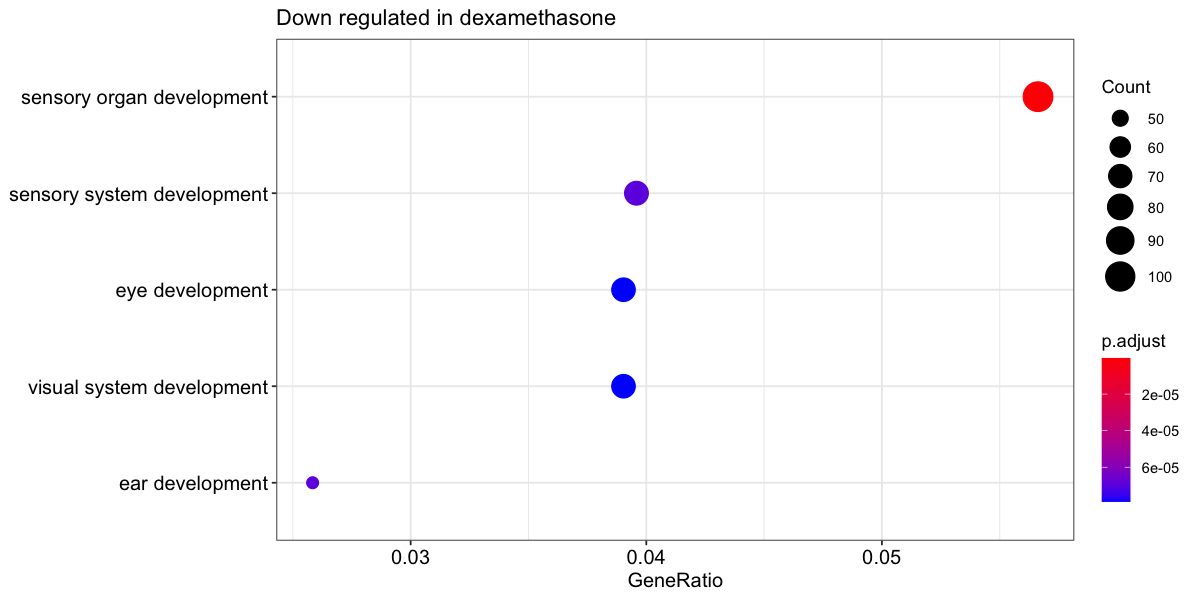

In [26]:
up_ego <- enrichGO(gene = rownames(up_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(up_ego, showCategory = 5) + ggtitle('Up regulated in dexamethasone')

down_ego <- enrichGO(gene = rownames(down_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(down_ego, showCategory = 5) + ggtitle('Down regulated in dexamethasone')

Note that in each of the calls to `enrichGO` above, I have specified the `universe` argument so that we are taking into consideration which genes were actually detected in our experiment. We also used the `ont = 'BP'` argument to tell `enrichGO` that we want to look at genes in the Biological Process category. We can also set the `showCategory = 5` argument in the call to `dotplot` to tell it to only show us the first 5 categories. The enrichment of `response to peptide hormone` in the up regulated genes makes sense, as dexamethasone is a corticosteroid hormone. 

In this example, we are running `enrichGO` on the up and down regulated genes separately, but it is also valid to run all of the differentially expressed genes together, depending on your research question. https://royalsocietypublishing.org/doi/10.1098/rsif.2013.0950

<div class="alert alert-block alert-success"><b>Exercise:</b> Try running `enrichGO` without setting the `universe` argument. How does this change your results? </div>

<div class="alert alert-block alert-success"><b>Exercise:</b> Try running `enrichGO` on all of the differentially expressed genes without pre-splitting into up and down regulated genes. How does this change your results? </div>

### Gene co-expression clustering

You might also be interested in looking at genes that are up or down regulated in some coordinated way across your conditions. We can use the `WGCNA` package to make weighted gene co-expression networks to find clusters or modules of highly correlated genes. The following section is pulled mainly from the WGCNA documentation, which is here:https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/ and the FAQ, which is here: https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html 

<div class="alert alert-block alert-warning"><b>Note:</b> You should have at least 20 samples and can filter your genes by overall expression level or variance but should **not** filter based on differential expression.</div>


Load the `WGCNA` package and make a dataframe of the rlog normalized counts for the 1000 most highly expressed genes.

In [47]:
#BiocManager::install("WGCNA")
library('WGCNA')

In [55]:
top_genes <- res %>% slice_max(baseMean, n = 1000) # get top 1000 genes
normalized_counts <- rlog(assays(dds)$counts) # get all rlog counts
rownames(normalized_counts) <- rownames(assays(dds)$counts) # set the rownames

top_genes_norm <- inner_join(tibble::rownames_to_column(data.frame(top_genes), 'gene_id'), 
                   tibble::rownames_to_column(data.frame(normalized_counts), 'gene_id'), 
                   by = 'gene_id') %>% dplyr::select(-baseMean, -log2FoldChange, -lfcSE, -pvalue, -padj, -stat) # use inner-join to get normalized counts for top 1000 genes
rownames(top_genes_norm) <- top_genes_norm$gene_id # re-set rownames
top_genes_norm <- dplyr::select(top_genes_norm, -gene_id) # drop extra gene_id column

Chose a set of soft-thresholding powers which will be used later to power the correlation of the genes.

In [58]:
powers <- c(c(1:10), seq(from = 12, to=20, by=2))

Transpose the normalized expression matrix because WGCNA expects the rows to be samples and columns to be genes

In [59]:
datExpr <- t(top_genes_norm)

Use some informative column names

In [60]:
colnames(datExpr) <- rownames(top_genes_norm)

Run the analysis of scale free topology for multiple soft thresholding powers. The aim is to help us pick an appropriate soft-thresholding power for network construction. This can be a bit slow.

In [61]:
sft <- pickSoftThreshold(data = datExpr, 
                         dataIsExpr = TRUE, 
                         corFnc = 'bicor', 
                         networkType = 'unsigned', 
                         verbose = 5)

pickSoftThreshold: will use block size 1000.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1000 of 1000
   Power SFT.R.sq    slope truncated.R.sq mean.k. median.k. max.k.
1      1 0.827000  3.62000          0.909  406.00    402.00  540.0
2      2 0.655000  1.45000          0.947  230.00    218.00  374.0
3      3 0.255000  0.48600          0.831  151.00    135.00  287.0
4      4 0.000155  0.00869          0.715  107.00     91.70  233.0
5      5 0.238000 -0.32700          0.742   80.50     66.90  196.0
6      6 0.526000 -0.52400          0.810   62.90     50.50  168.0
7      7 0.649000 -0.64700          0.822   50.50     39.00  147.0
8      8 0.758000 -0.75900          0.881   41.50     30.90  130.0
9      9 0.832000 -0.84800          0.895   34.80     24.80  116.0
10    10 0.887000 -0.92700          0.923   29.50     20.30  104.0
11    12 0.909000 -1.02000          0.934   22.00     14.10   86.3
12    14 0.947000 -1.07000          0.963

We are giving the function our normalized counts (not a similarity matrix), so use `dataIsExpr = TRUE`, we use `corFnc = 'bicor'` because it is median-based and is less sensitive to outliers, and we use `networkType = 'unsigned'` so that we allow modules to contain correlated genes regardless of the directon of their differential expression (e.g., we allow for the scenario where one gene is up regulated while the other is down regulated in a coordinated way).    

Now we will make some plots to help us pick some thresholds:

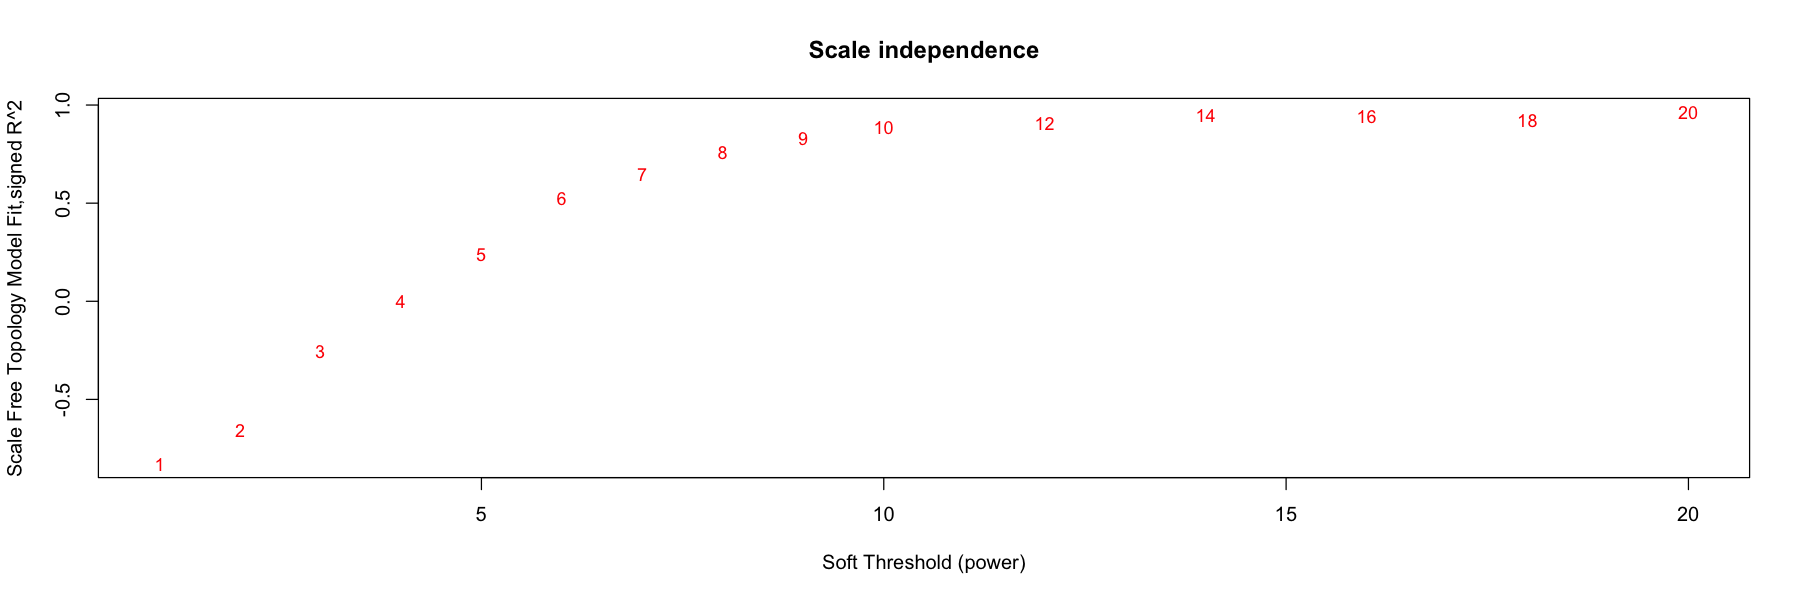

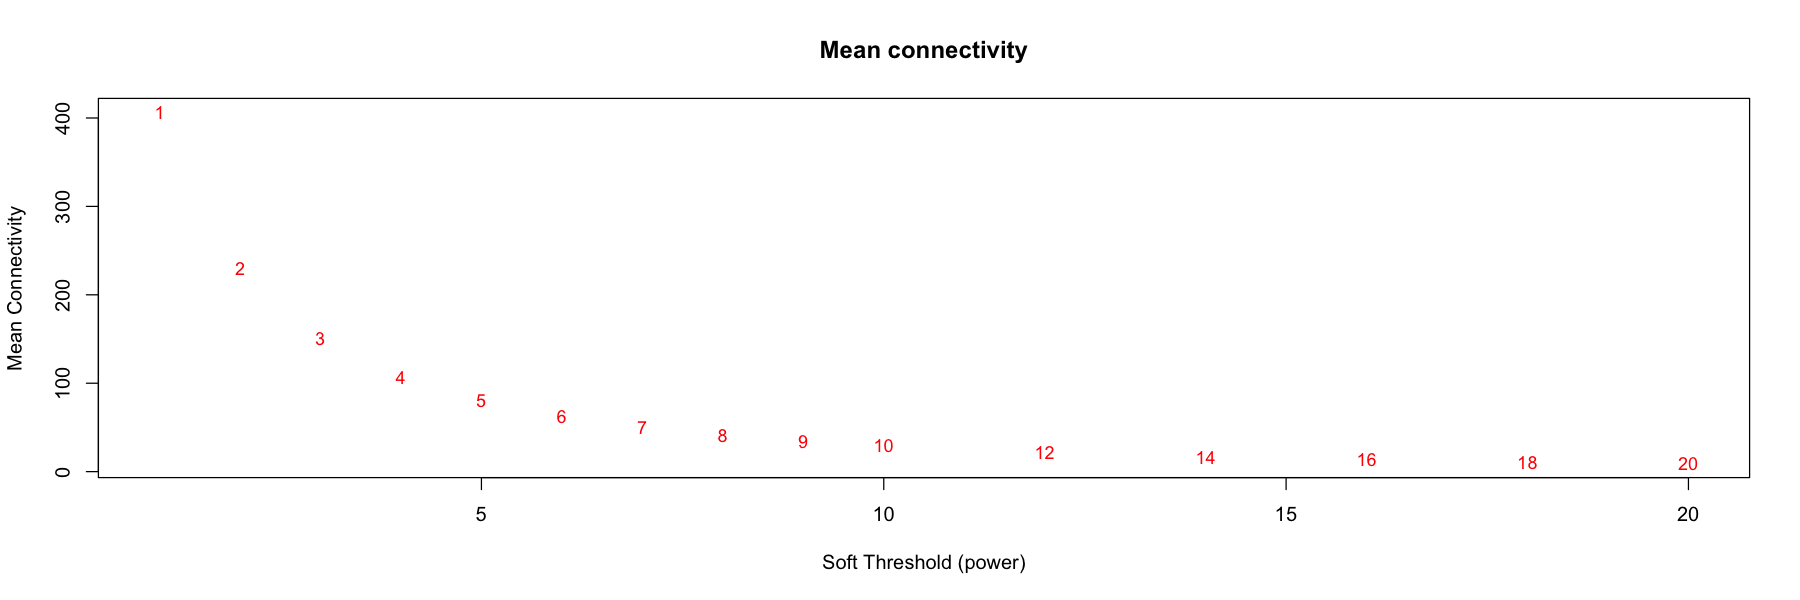

In [62]:
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices$Power, 
     -sign(sft$fitIndices$slope)*sft$fitIndices$SFT.R.sq,
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",
     main = paste("Scale independence"))

text(sft$fitIndices$Power,
     -sign(sft$fitIndices$slope)*sft$fitIndices$SFT.R.sq,
     labels=powers,
     cex=.9,
     col="red")

# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices$Power, 
     sft$fitIndices$mean.k,
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity", 
     type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices$Power,
     sft$fitIndices$mean.k, 
     labels=powers, 
     cex=.9,
     col="red")

Based on these plots, we get diminishing returns on the goodness of the fit to the scale free model once our soft threshold reaches ~8-10. Let's build the network and detect the modules:

In [83]:
net <- blockwiseModules(datExpr, 
                        power = 10,
                        TOMType = "unsigned", 
                        minModuleSize = 30, 
                        reassignThreshold = 0, 
                        mergeCutHeight = 0.25,
                        numericLabels = TRUE, 
                        pamRespectsDendro = FALSE,
                        verbose = 3,
                        randomSeed=42)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 1 genes from module 1 because their KME is too low.
     ..removing 1 genes from module 5 because their KME is too low.
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...


In [ ]:
The module assigments are in the `colors` slot, which can be accessed using `$`:

In [114]:
table(net$colors)
head(data.frame(net$colors))


  0   1   2   3   4   5   6   7 
  5 403 246 125  64  58  56  43 

,net.colors
,<dbl>
ENSG00000115414,2
ENSG00000011465,2
ENSG00000198804,2
ENSG00000156508,3
ENSG00000164692,1
ENSG00000116260,2


There are 7 modules labeled 1-7, while module 0 is unassigned.

This is just one example of how you can use network approaches to interpret your RNA-seq data and find associations between genes. Other approaches use Gaussian graphical models (GGMs) and/or mixed graphical models (MGMs). These approaches can be used for very large expresssion matrices (e.g., single cell data) and can be extended to include other covariates (e.g., information about treatment groups or time points). There's a nice review here: https://doi.org/10.1016/j.bbagrm.2019.194418. You can also use the `stringDB` package if you're interested in looking at protein:protein interactions.

# Appendix A

One easy-to-use GUI-based method for ontology analysis is [DAVID](https://david.ncifcrf.gov/) - this tool has sample datasets within it that can be used to preview its functions.  It does not lend itself well for use in this workshop, due to the need to write to files and then input those files into DAVID, which would require some further explanation due to the Jupyter environment.  Users should feel free to visit the site and use the example data, though.

#  Hypothesis testing for count data


Generalized Linear Models (GLM) are a broad family of regression models, a small subset of which form the basis for differential expression and other hypothesis testing in genomics.

The components of a GLM are:

$$
g\left( E[y|x] \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$

* **Random component** specifies the conditional distribution for the response variable
    + doesn’t have to be normal
    + can be any distribution in the "exponential" family of distributions
* **Systematic component** specifies linear function of predictors (linear predictor)
* **Link** [denoted by g(.)] specifies the relationship between the expected value of the random component and the systematic component
    + can be linear or nonlinear  

## Linear Regression as GLM

This is useful for log-transformed microarray data:

* **The model**: $y_i = E[y|x] + \epsilon_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + \epsilon_i$
* **Random component** of $y_i$ is normally distributed:   $\epsilon_i \stackrel{iid}{\sim} N(0, \sigma_\epsilon^2)$
* **Systematic component** (linear predictor): $\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$
* **Link function** here is the _identity link_: $g(E(y | x)) = E(y | x)$.  We are modeling the mean directly, no transformation.

## Logistic Regression as GLM

This is useful for binary outcomes, e.g. Single Nucleotide Polymorphisms or somatic variants:

* **The model**: 
$$
Logit(P(x)) = log \left( \frac{P(x)}{1-P(x)} \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$
* **Random component**: $y_i$ follows a Binomial distribution (outcome is a binary variable)
* **Systematic component**: linear predictor 
$$
\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$
* **Link function**: _logit_ (log of the odds that the event occurs)
$$
g(P(x)) = logit(P(x)) = log\left( \frac{P(x)}{1-P(x)} \right)
$$

## Log-linear GLM

This is useful for count data, like RNA-seq. It can:
    + account for differences in sequencing depth
    + guarantee non-negative expected number of counts
    + be used in conjunction with Poisson or Negative Binomial error models

* **The model** (`log(t_i)` is called an "offset" term):
$$
log\left( E[y|x] \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + log(t_i)  
$$

Without getting into details of Poisson or Negative Binomial error terms, they are just random distributions that happen to fit many count data well:

In [ ]:
options(repr.plot.height=5, repr.plot.width=7)
plot(x=0:40, y=dnbinom(0:40, size=10, prob=0.5), 
     type="b", lwd=2, ylim=c(0, 0.15),
     xlab="Counts (k)", ylab="Probability density")
lines(x=0:40, y=dnbinom(0:40, size=20, prob=0.5), 
      type="b", lwd=2, lty=2, pch=2)
lines(x=0:40, y=dnbinom(0:40, size=10, prob=0.3),
      type="b", lwd=2, lty=3, pch=3)
lines(x=0:40, y=dpois(0:40, lambda=9), col="red")
lines(x=0:40, y=dpois(0:40, lambda=20), col="red")
legend("topright", lwd=c(2,2,2,1), lty=c(1:3,1), pch=c(1:3,-1), col=c(rep("black", 3), "red"),
       legend=c("n=10, p=0.5", "n=20, p=0.5", "n=10, p=0.3", "Poisson"))

**Figure**: Two Poisson distributions (shown as red lines), and three Negative Binomial (NB) distributions selected for having similarly located peak probabilities. Note the greater dispersion and the tunability of NB distribution. Also note that probabilities are only non-zero defined for integer values.

#  Small samples, large samples, and the Central Limit Theorem

## What is a _sampling distribution_?

It is the distribution of a statistic for many samples taken from one population.
 
1. Take a sample from a population
2. Calculate the sample statistic (e.g. mean)
3. Repeat.  

- The values from (2) form a sampling distribution.
- The standard deviation of the sampling distribution is the _standard error_

- Question: how is this different from a population distribution?

## Example: population and sampling distributions

We observe 100 counts from a Poisson distribution ($\lambda = 2$). 
* Question: is this a population or a sampling distribution?

In [ ]:
options(repr.plot.height=3, repr.plot.width=3)
set.seed(1)
onesample=rpois(100, lambda=2)
xdens = seq(min(onesample), max(onesample), by=1)
ydens = length(onesample) * dpois(xdens, lambda=2)
par(mar=c(2, 4, 0.1, 0.1))
options(repr.plot.width=4, repr.plot.height=3)
res=hist(onesample, main="", prob=FALSE, col="lightgrey", xlab="", ylim=c(0, max(ydens)),
     breaks=seq(-0.5, round(max(onesample))+0.5, by=0.5))
lines(xdens, ydens, lw=2)

We calculate the *mean* of those 100 counts, and do the same for 1,000 more samples of 100:
* Question: is this a population or a sampling distribution?

In [ ]:
set.seed(1)
samplingdistr=replicate(1000, mean(rpois(100, lambda=2)))
par(mar=c(4, 4, 0.1, 0.1))
res=hist(samplingdistr, xlab="Means of the 100-counts", main="")
dy=density(samplingdistr, adjust=2)
## Note this next step is just an empirical way to put the density line approximately the same scale as the histogram:
dy$y = dy$y / max(dy$y) * max(res$counts)
lines(dy)

## Central Limit Theorem

The "CLT" relates the sampling distribution (of means) to the population distribution.

1. Mean of the population ($\mu$) and of the sampling distribution ($\bar{X}$) are identical
2. Standard deviation of the population ($\sigma$) is related to the standard deviation of the distribution of sample means (*Standard Error* or *SE*) by: 
$$
SE = \sigma / \sqrt{n}
$$
3. For large n, the shape of the sampling distribution of means becomes normal

### CLT 1: equal means

Recall Poisson distributed population and samples of n=30:

In [ ]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
hist(onesample, main="One sample of 100 counts\n from Poisson(lambda=2)", xlab="counts")
abline(v=2, col="red", lw=2)
res=hist(samplingdistr, xlab="Means of the 100-counts", main="1000 samples\n of n=100")
abline(v=2, col="red", lw=2)

- Distributions are different, but means are the same

### CLT 2: Standard Error

Standard deviation of the sampling distribution is $SE = \sigma / \sqrt{n}$:

In [ ]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,3))
hist(replicate(1000, mean(rpois(30, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 30-counts", main="1000 samples\n of n=30")
abline(v=2, col="red", lw=2)
hist(replicate(1000, mean(rpois(100, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 100-counts", main="1000 samples\n of n=100")
abline(v=2, col="red", lw=2)
hist(replicate(1000, mean(rpois(500, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 500-counts", main="1000 samples\n of n=500")
abline(v=2, col="red", lw=2)

### CLT 3: large samples

- The distribution of means of large samples is normal. 
    + for large enough n, the population distribution doesn't matter. How large?
    + n < 30: population is normal or close to it
    + n >= 30: skew and outliers are OK
    + n > 500: even extreme population distributions

*Example*: an extremely skewed (log-normal) distribution:

In [ ]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,3))
set.seed(5)
onesample=rlnorm(n=100, sdlog=1.5)
hist(onesample, main="100 observations\n from lognormal pop'n", xlab="counts")
sampling30=replicate(1000, mean(rlnorm(n=30, sdlog=1.5)))
hist(sampling30, xlab="Means of the 100 obs.", main="1000 samples\n of n=30")
sampling1000=replicate(1000, mean(rlnorm(n=1000, sdlog=1.5)))
hist(sampling1000, xlab="Means of the 1000 obs.", main="1000 samples\n of n=1000")

#  Correcting for batch effects

Suppose we did not know that there were different cell lines involved
in the experiment, only that there was treatment with
dexamethasone. The cell line effect on the counts then would represent
some hidden and unwanted variation that might be affecting
many or all of the genes in the dataset. We can use statistical
methods designed for RNA-seq from the 
[sva](http://www.bioconductor.org/packages/Gviz) package to
detect such groupings of the samples, and then we can add these to the
*DESeqDataSet* design, in order to account for them. The *SVA*
package uses the term *surrogate variables* for the estimated
variables that we want to account for in our analysis. Another
package for detecting hidden batches is the [RUVSeq](http://www.bioconductor.org/packages/RUVSeq)
package, with the acronym "Remove Unwanted Variation".

In [ ]:
suppressPackageStartupMessages(library(sva))

Below we obtain a matrix of normalized counts for which the average count across
samples is larger than 1. As we described above, we are trying to
recover any hidden batch effects, supposing that we do not know the
cell line information. So we use a full model matrix with the
*dex* variable, and a reduced, or null, model matrix with only
an intercept term. Finally we specify that we want to estimate 2
surrogate variables. For more information read the manual page for the
*svaseq* function by typing `?svaseq`.

In [ ]:
dat  <- counts(dds, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~ dex, colData(dds))
mod0 <- model.matrix(~   1, colData(dds))
svseq <- svaseq(dat, mod, mod0, n.sv = 2)

In [ ]:
svseq$sv

Because we actually do know the cell lines, we can see how well the
SVA method did at recovering these variables (figure below).

In [ ]:
options(repr.plot.height=5)
par(mfrow = c(2, 1), mar = c(3,5,3,1))
for (i in 1:2) {
  stripchart(svseq$sv[, i] ~ dds$cell, vertical = TRUE, main = paste0("SV", i))
  abline(h = 0)
 }

![](BrownCOBREDay2Session2_files/figure-html/svaplot-1.png)<!-- -->

**Surrogate variables 1 and 2 plotted over cell line.**
Here, we know the hidden source of variation (cell line), and
therefore can see how the SVA procedure is able to identify a source
of variation which is correlated with cell line.

Finally, in order to use SVA to remove any effect on the counts from
our surrogate variables, we simply add these two surrogate variables
as columns to the *DESeqDataSet* and then add them to the design:

In [ ]:
ddssva <- dds
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + dex

We could then produce results controlling for surrogate variables by
running *DESeq* with the new design:

In [ ]:
DESeq(ddssva)



## Gene clustering

In the sample distance heatmap made in our previous workshop, the dendrogram at the
side shows us a hierarchical clustering of the samples. Such a
clustering can also be performed for the genes.  Since the clustering
is only relevant for genes that actually carry a signal, one usually
would only cluster a subset of the most highly variable genes. Here,
for demonstration, let us select the 20 genes with the highest
variance across samples. We will work with the *rlog*-transformed
counts:

In [ ]:
rld <- rlog(dds, blind=FALSE, fitType="mean")
suppressPackageStartupMessages(library(genefilter))
topVarGenes <- head(order(rowVars(assay(rld)), decreasing = TRUE), 20)

The heatmap becomes more interesting if we do not look at absolute
expression strength but rather at the amount by which each gene
deviates in a specific sample from the gene's average across all
samples. Hence, we center each genes' values across samples,
and plot a heatmap (figure below). We provide a *data.frame* that instructs the
*pheatmap* function how to label the columns.

In [ ]:
library(pheatmap)
mat  <- assay(rld)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(rld)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)


**Heatmap of relative rlog-transformed values across samples.**
Treatment status and cell line information are shown with colored bars
at the top of the heatmap.
Blocks of genes that covary across patients. Note that
a set of genes at the top of the heatmap are separating the N061011
cell line from the others. In the center of the heatmap, we see a set
of genes for which the dexamethasone treated samples have higher gene
expression. 

## Stratified random sampling
- done with population sampling

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/StratifiedRandomSampling.jpg" alt="SRS" style="width:400px"> 

- divides population into more homogeneous subpopulations
    + during design, strata are normally with predetermined probabilities
 
## Stratification in analysis
- experimental blocks and population strata could either be treated as factors or strata for analysis
    + stratification is necessary when you think a factor in a linear model is inadequate to capture differences between nuisance strata
- observations are:
    + divided into strata
    + strata are analyzed independently
    + results are then averaged across strata

# Answer to Exercise (Coding variable as non-factor in design matrix)

In [ ]:
# Example of design matrix with the group variable not coded as a factor
group <- c(1, 1, 2, 2)  
model.matrix(~ group)